In [30]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_v1_tuning"
schema = dj.schema("nnfabrik_v1_tuning")

import os
from os import listdir
from os.path import isfile, join


import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.8/dist-packages/datajoint/connection.py:218: UserWarning:

MySQL server has gone away. Reconnecting to the server.



In [31]:
# loading model
ensemble_hash = 'e7a8d0b961ee37ffda0779bfed95f1cf'
dataset_hash = 'a737408da40cfedd036c2eb1b8a31ff1'
model_hash = 'f8bcd882c48a55dc6cd6d7afb656f1f9' # monkey
# model_hash = 'a09d55344b5793137349b8ca5d17d46d' # mouse

# model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
model_key = (TrainedModel & dict(model_hash=model_hash)).fetch("KEY", limit=1, order_by="score DESC")
dataloaders, model = TrainedModel().load_model(model_key, include_dataloader=True)
model.eval()

# model specifics for optimization
data_key = '3631807112901' # monkey
# data_key = '22564-3-12-0' # mouse
unit_idx = 27
unit_id = 26

# number of model neurons 
n_units = model.readout[data_key].outdims

# image dimensions
w, h = 41, 41 # monkey
# w, h = 64, 36 # mouse

next(iter(dataloaders['train'][data_key]))[0].shape

torch.Size([128, 1, 41, 41])

In [32]:
# Finite Set
canvas_size         = [w, h]
sizes               = FiniteParameter([float(val) for val in range(5, 31)][::5])
spatial_frequencies = FiniteParameter([float(val) for val in np.linspace(1/80, 2/5, 10)])
contrasts           = FiniteParameter([.5])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 10)])
phases              = FiniteParameter([float(val) for val in np.linspace(0.0, 2*np.pi, 10)]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([float(val) for val in np.linspace(0.0, 0.99, 5)])
locations           = FiniteParameter([[float(x), float(y)] for x in range(12, 28) 
                                                            for y in range(12, 28)][::16])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

In [33]:
start_time = time.time()

best_params_list = []
values_list = []

for unit in range(0, n_units):
    best_params, values = gabor_set.find_optimal_stimulus_bruteforce(model=model, data_key=data_key, unit_idx=unit)
    best_params_list.append(best_params)
    values_list.append(values)

print("--- %s seconds ---" % (time.time() - start_time))

 76%|███████▌  | 3657/4800 [08:24<02:37,  7.25it/s]


KeyboardInterrupt: 

In [ ]:
for best_param in best_params_list:
    best_param['location_width'] = best_param['location'][0]
    best_param['location_height'] = best_param['location'][1]

In [ ]:
def get_responses(model, data_key, best_params_list, gabor_set, n_units):
    for unit in range(n_units):
        best_gabor_img = gabor_set.get_image_from_params(best_params_list[unit])
        image = torch.tensor(best_gabor_img).expand(1, 1, h, w).float()

        response = model(image, data_key=data_key).detach().numpy().squeeze()

        yield response

responses = np.array(list(get_responses(model, data_key, best_params_list, gabor_set, n_units)))

In [19]:
def get_random_responses(model, data_key, unit):
    images = np.random.randn(1000, 1, h, w)
    images = torch.tensor(images).float()

    output = model(images, data_key=data_key).detach().numpy().squeeze()

    return np.mean(output[:, unit]), np.std(output[:, unit])

unit = 5
rnd_mean, rnd_std = get_random_responses(model, data_key, unit)

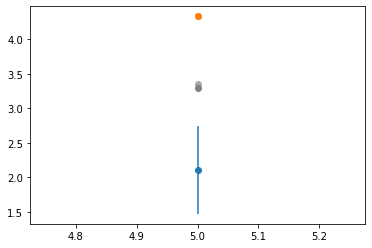

In [20]:
gabor_idx_desc = np.array(responses).argsort(0)[::-1].T

res_opt = np.array(responses)[unit, unit]
res_0 = np.array(responses)[gabor_idx_desc[unit, 0], unit]
res_1 = np.array(responses)[gabor_idx_desc[unit, 1], unit]
res_2 = np.array(responses)[gabor_idx_desc[unit, 2], unit]

plt.figure()

plt.errorbar([unit], [rnd_mean], yerr=[rnd_std], fmt='o', c='tab:blue', label='random response')
plt.scatter([unit], [res_0], c='silver', label='1')
plt.scatter([unit], [res_1], c='#aaa', label='2')
plt.scatter([unit], [res_2], c='gray', label='3')
plt.scatter([unit], [res_opt], c='tab:orange', label='optimal')

plt.show()

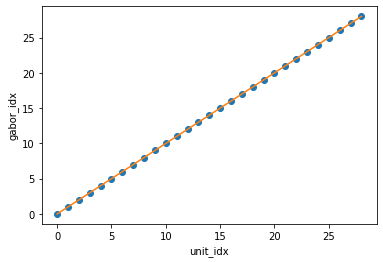

In [21]:
plt.scatter(np.arange(29), np.array(responses).argmax(0)[:29])
plt.plot(np.arange(29), np.arange(29), c='tab:orange')
plt.xlabel('unit_idx')
plt.ylabel('gabor_idx')
plt.show()

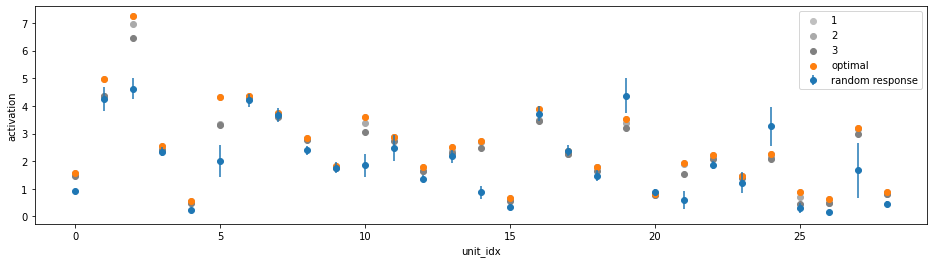

In [45]:
gabor_idx_desc = np.array(responses).argsort(0)[::-1].T

images = np.random.randn(100, 1, h, w)
images = torch.tensor(images).float()

output = model(images, data_key=data_key).detach().numpy()

mean_random_activations = []
std_random_activations = []
for unit in range(n_units):
    mean_random_activations.append(np.mean(output[:, unit]))
    std_random_activations.append(np.std(output[:, unit]))

plt.figure(figsize=(16, 4))
plt.errorbar(np.arange(29), mean_random_activations[:29], yerr=std_random_activations[:29], fmt='o', c='tab:blue', label='random response')

responses_per_unit = []
for unit in range(29):
    res_opt = np.array(responses)[unit, unit]
    res_0 = np.array(responses)[gabor_idx_desc[unit, 0], unit]
    res_1 = np.array(responses)[gabor_idx_desc[unit, 1], unit]
    res_2 = np.array(responses)[gabor_idx_desc[unit, 2], unit]

    responses_per_unit.append((res_opt, res_0, res_1, res_2))
responses_per_unit = np.array(responses_per_unit)

plt.scatter(np.arange(29), responses_per_unit[:29, 1], c='silver', label='1')
plt.scatter(np.arange(29), responses_per_unit[:29, 2], c='#aaa', label='2')
plt.scatter(np.arange(29), responses_per_unit[:29, 3], c='gray', label='3')
plt.scatter(np.arange(29), responses_per_unit[:29, 0], c='tab:orange', label='optimal')


# plt.xlim(-0.5, 0.5)
plt.legend()
plt.xlabel('unit_idx')
plt.ylabel('activation')
plt.savefig('imgs/vs_random.png', dpi=300)
plt.show()

## Quicker Bruteforce

In [34]:
best_params, values = gabor_set.find_optimal_stimulus_bruteforce(model=model, data_key=data_key)

100%|██████████| 4800/4800 [10:42<00:00,  7.48it/s]


In [37]:
for best_param in best_params:
    best_param['location_width'] = best_param['location'][0]
    best_param['location_height'] = best_param['location'][1]

In [38]:
responses = np.array(list(get_responses(model, data_key, best_params, gabor_set, n_units)))

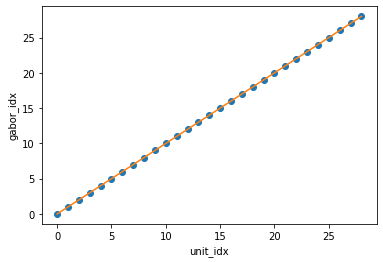

In [41]:
plt.scatter(np.arange(29), np.array(responses).argmax(0)[:29])
plt.plot(np.arange(29), np.arange(29), c='tab:orange')
plt.xlabel('unit_idx')
plt.ylabel('gabor_idx')
plt.savefig('imgs/gab_vs_unit_monkey_bruteforce.png', dpi=300)
plt.show()